# 実装: Rによる状態空間モデル

In [1]:
# ライブラリのインストール
install.packages("dlm")
install.packages("KFAS")

package 'dlm' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\masayoshi\AppData\Local\Temp\RtmpUJitD7\downloaded_packages
package 'KFAS' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\masayoshi\AppData\Local\Temp\RtmpUJitD7\downloaded_packages


In [2]:
# ライブラリの読み込み
library(dlm)
library(KFAS)
library(ggplot2)
library(ggfortify)

# 図示設定
library(repr)

# グラフのオプション
options(repr.plot.width=14, repr.plot.height=6)


Attaching package: 'ggplot2'


The following object is masked from 'package:dlm':

    %+%




- dlm: カルマンフィルタを用いて状態空間モデルを推定するパッケージ
- KFAS: 散漫カルマンフィルタを用いて状態空間モデルを推定するパッケージ

## 分析の対象

- ナイル川の流量データを分析の対象
    - 1年に1回だけ観測され、1871年~1970年まで100年間取得されたデータ

In [4]:
# データ
print(Nile)

Time Series:
Start = 1871 
End = 1970 
Frequency = 1 
  [1] 1120 1160  963 1210 1160 1160  813 1230 1370 1140  995  935 1110  994 1020
 [16]  960 1180  799  958 1140 1100 1210 1150 1250 1260 1220 1030 1100  774  840
 [31]  874  694  940  833  701  916  692 1020 1050  969  831  726  456  824  702
 [46] 1120 1100  832  764  821  768  845  864  862  698  845  744  796 1040  759
 [61]  781  865  845  944  984  897  822 1010  771  676  649  846  812  742  801
 [76] 1040  860  874  848  890  744  749  838 1050  918  986  797  923  975  815
 [91] 1020  906  901 1170  912  746  919  718  714  740


In [5]:
# サンプルサイズ
length(Nile)

[1] 100

## Rで実装するカルマンフィルタ: 関数を作る

In [6]:
kfLocalLevel <- function(y, mu_pre, P_pre, sigma_w, sigma_v){
    # Step1 予測
    mu_forecast <- mu_pre
    P_forecast <- P_pre + sigma_w
    y_forecast <- mu_forecast
    F <- P_forecast + sigma_v
    
    # Step2 フィルタリング(状態の補正)
    K <- P_forecast / (P_forecast + sigma_v)
    y_resid <- y - y_forecast
    mu_filter <- mu_forecast + K * y_resid
    P_filter <- (1 - K) * P_forecast
    
    # 結果の格納
    result <- data.frame(
        mu_filter = mu_filter,
        P_filter = P_filter,
        y_resid = y_resid,
        F = F,
        K = K
    )
    return(result)
}

## Rで実装するカルマンフィルタ: 状態を推定する

カルマンフィルタ関数を時点をずらしながら何度も実行することで、フィルタ化推定量を求めることができる。  
状態の初期値は0, 状態の予測誤差の分散の初期値は10の7乗としておく。

In [10]:
# サンプルサイズ
N <- length(Nile)

# 状態の推定値
mu_filter <- numeric(N)

# 「状態」の初期値は0とする
mu_zero <- 0
mu_filter <- c(mu_zero, mu_filter)

# 状態の予測誤差の分散
P_filter <- numeric(N)

# 「状態の予測誤差の分散」の初期値は10000000にする
P_zero <- 10000000
P_filter <- c(P_zero, P_filter)

In [11]:
# 観測値の予測残差
y_resid <- numeric(N)

# 観測値の予測誤差の分散
F <- numeric(N)

# カルマンゲイン
K <- numeric(N)

In [16]:
print(length(mu_filter))
print(length(P_filter))
print(length(F))
print(length(K))

[1] 101
[1] 101
[1] 100
[1] 100


In [17]:
# 過程誤差の分散
sigma_w <- 1000

# 観測誤差の分散
sigma_v <- 10000

In [18]:
# 実行
# 時点をずらしながら、連続で実行させる
for(i in 1:N){
    kekka <- kfLocalLevel(
        y = Nile[i], mu_pre = mu_filter[i], P_pre = P_filter[i],
        sigma_w = sigma_w, sigma_v = sigma_v
    )
    mu_filter[i + 1] <- kekka$mu_filter
    P_filter[i + 1] <- kekka$P_filter
    y_resid[i] <- kekka$y_resid
    F[i] <- kekka$F
    K[i] <- kekka$K
}

In [19]:
print(mu_filter)

  [1]    0.0000 1118.8812 1140.4103 1072.2709 1117.1955 1129.9866 1138.5439
  [8] 1048.0302 1097.9501 1172.0492 1163.3531 1117.7658 1068.3295 1079.5944
 [15] 1056.4625 1046.6101 1023.2095 1065.5697  993.5522  983.9474 1026.1063
 [22] 1046.0692 1090.3562 1106.4694 1145.2451 1176.2469 1188.0670 1145.3642
 [29] 1133.1088 1036.0933  983.1175  953.6387  883.4957  898.7607  880.9950
 [36]  832.3683  854.9619  810.9367  867.4165  916.7425  930.8602  903.8824
 [43]  855.8263  747.8108  768.3938  750.4571  850.2914  917.7517  894.5854
 [50]  859.3069  848.9581  827.0867  831.9261  840.5911  846.3748  806.2904
 [57]  816.7481  797.0947  796.7990  862.5012  834.5397  820.0756  832.2122
 [64]  835.6669  864.9338  897.1003  897.0732  876.7917  912.7787  874.4763
 [71]  820.8567  774.4286  793.7640  798.6906  783.3753  788.1367  856.1791
 [78]  857.2114  861.7469  858.0331  866.6692  833.5293  810.6932  818.0703
 [85]  880.7276  890.7969  916.5166  884.2285  894.7028  916.3956  889.0030
 [92]  924.3

## Rで実装するカルマンフィルタの対数尤度

最適なパラメタを求めるために、対数尤度を計算する。  
y_residが、期待値=0, 分散=観測地の予測誤差の分散(F)の正規分布に従うことを利用する。

In [20]:
# 正規分布の確立光男を計算してくれるdnorm関数を用いて対数尤度を求める
sum(log(dnorm(y_resid, mean=0, sd=sqrt(F))))

[1] -646.3254

In [22]:
# 正規分布の各地る密度関数を直接用いて計算も可能
-1 * (N/2) * log(2 * pi) - 1/2 * sum(log(F) + y_resid^2 / F)

[1] -646.3254

## Rで実装する最尤法

対数尤度を最大にするパラメタを求めたい。  
sigma_w, sigma_vを入れると、即座に対数尤度を計算してくれる関数を作る。  

In [23]:
calkLogLik <- function(sigma) {
    sigma_w <- exp(sigma[1])  # 分散は負にならないのでEXPを取る
    sigma_v <- exp(sigma[2])  # 分散は負にならないのでEXPを取る
    
    # 変数の定義
    N <- length(Nile)
    mu_filter <- numeric(N)
    mu_zero <- 0
    mu_filter <- c(mu_zero, mu_filter)
    P_filter <- numeric(N)
    P_zero <- 10000000
    P_filter <- c(P_zero, P_filter)
    y_resid <- numeric(N)
    F <- numeric(N)
    K <- numeric(N)
    # カルマンフィルタの実行
    for(i in 1:N){
        kekka <- kfLocalLevel(
            y = Nile[i], mu_pre = mu_filter[i], P_pre = P_filter[i],
            sigma_w = sigma_w, sigma_v = sigma_v
        )
        mu_filter[i + 1] <- kekka$mu_filter
        P_filter[i + 1] <- kekka$P_filter
        y_resid[i] <- kekka$y_resid
        F[i] <- kekka$F
        K[i] <- kekka$K
    }
    return(1/2 * sum(log(F) + y_resid^2 / F))
}

In [24]:
best_sigma <- optim(calkLogLik, par=c(1, 1), method="L-BFGS")
exp(best_sigma$par)

[1]  1468.461 15099.836

## Rで実装する平滑化: 関数を作る

平滑化はフィルタリングが終わった後に行う作業。  

In [26]:
smoothLocalLevel <- function(mu_filterd, P_filterd, r_post, s_post,
                            F_post, y_resid_post, K_post){
    # 状態平滑化漸化式
    r <- y_resid_post/F_post + (1 - K_post) * r_post
    mu_smooth <- mu_filterd + P_filterd * r
    
    # 状態分散平滑化漸化式
    s <- 1/F_post + (1 - K_post)^2 * s_post
    P_smooth <- P_filterd - P_filterd^2 * s
    
    # 結果の格納
    result <- data.frame(
        mu_smooth = mu_smooth,
        P_smooth = P_smooth,
        r = r,
        s = s
    )
    
    return(result)
}

- _postで1時点未来の情報

## Rで実装する平滑化: 状態を推定する

In [27]:
# 平滑化状態
mu_smooth <- numeric(N + 1)

# 平滑化状態分散
P_smooth <- numeric(N + 1)

# 漸化式のパラメタ(初期値は0のまま)
r <- numeric(N)
s <- numeric(N)

# 最後のデータは、フィルタリングの結果とスムージングの結果が一致する
mu_smooth[N + 1] <- mu_filter[N + 1]
P_smooth[N + 1] <- P_filter[N + 1]

In [28]:
# 未来から過去へ
for(i in N:1){
    kekka <- smoothLocalLevel(
        mu_filter[i], P_filter[i], r[i], s[i], F[i], y_resid[i], K[i]
    )
    mu_smooth[i] <- kekka$mu_smooth
    P_smooth[i] <- kekka$P_smooth
    r[i - 1] <- kekka$r
    s[i - 1] <- kekka$s
} 

In [29]:
print(mu_smooth)

  [1] 1111.3728 1111.4840 1110.7435 1105.0774 1113.6190 1112.5225 1106.6783
  [8] 1095.5019 1112.5757 1117.9070 1098.0291 1073.9540 1057.7744 1053.8722
 [15] 1044.3572 1039.8779 1037.3864 1042.6336 1034.1441 1049.1690 1073.3109
 [22] 1090.7838 1107.3351 1113.6199 1116.2667 1105.5401 1079.3676 1039.1318
 [29]  999.8092  950.4676  918.7727  894.9550  873.2329  869.4340  858.5785
 [36]  850.2809  856.9114  857.6331  874.9180  877.6947  863.2409  838.2112
 [43]  813.9026  798.3843  817.1045  835.1350  866.4791  872.4711  855.7101
 [50]  841.3202  834.6624  829.3707  830.2162  829.5832  825.5086  817.7848
 [57]  822.0395  823.9982  833.9566  847.7108  842.2360  845.0848  854.3421
 [64]  862.5336  872.4785  875.2713  867.1911  856.1301  848.4821  824.6823
 [71]  806.2507  800.8442  810.6221  816.8622  823.5885  838.4736  857.1062
 [78]  857.4493  857.5374  855.9792  855.2190  850.9806  857.4403  874.7440
 [85]  895.7221  901.2725  905.1500  900.9426  907.1295  911.7293  910.0020
 [92]  917.7

## dlmによるカルマンフィルタ

In [43]:
# dlmのパラメタ設定
mod_dlm <- dlmModPoly(
    order = 1, m0 = 0, C0 = 10000000, dW = sigma_w, dV = sigma_v
)

# カルマンフィルタの実行
mu_filter_dlm <- dlmFilter(Nile, mod_dlm)

In [44]:
# フィルタ化推定量
print(mu_filter_dlm$m)

Time Series:
Start = 1870 
End = 1970 
Frequency = 1 
  [1]    0.0000 1118.8812 1140.4103 1072.2709 1117.1955 1129.9866 1138.5439
  [8] 1048.0302 1097.9501 1172.0492 1163.3531 1117.7658 1068.3295 1079.5944
 [15] 1056.4625 1046.6101 1023.2095 1065.5697  993.5522  983.9474 1026.1063
 [22] 1046.0692 1090.3562 1106.4694 1145.2451 1176.2469 1188.0670 1145.3642
 [29] 1133.1088 1036.0933  983.1175  953.6387  883.4957  898.7607  880.9950
 [36]  832.3683  854.9619  810.9367  867.4165  916.7425  930.8602  903.8824
 [43]  855.8263  747.8108  768.3938  750.4571  850.2914  917.7517  894.5854
 [50]  859.3069  848.9581  827.0867  831.9261  840.5911  846.3748  806.2904
 [57]  816.7481  797.0947  796.7990  862.5012  834.5397  820.0756  832.2122
 [64]  835.6669  864.9338  897.1003  897.0732  876.7917  912.7787  874.4763
 [71]  820.8567  774.4286  793.7640  798.6906  783.3753  788.1367  856.1791
 [78]  857.2114  861.7469  858.0331  866.6692  833.5293  810.6932  818.0703
 [85]  880.7276  890.7969  916.516

In [45]:
# パッケージを使わず実装した結果
print(mu_filter)

  [1]    0.0000 1118.8812 1140.4103 1072.2709 1117.1955 1129.9866 1138.5439
  [8] 1048.0302 1097.9501 1172.0492 1163.3531 1117.7658 1068.3295 1079.5944
 [15] 1056.4625 1046.6101 1023.2095 1065.5697  993.5522  983.9474 1026.1063
 [22] 1046.0692 1090.3562 1106.4694 1145.2451 1176.2469 1188.0670 1145.3642
 [29] 1133.1088 1036.0933  983.1175  953.6387  883.4957  898.7607  880.9950
 [36]  832.3683  854.9619  810.9367  867.4165  916.7425  930.8602  903.8824
 [43]  855.8263  747.8108  768.3938  750.4571  850.2914  917.7517  894.5854
 [50]  859.3069  848.9581  827.0867  831.9261  840.5911  846.3748  806.2904
 [57]  816.7481  797.0947  796.7990  862.5012  834.5397  820.0756  832.2122
 [64]  835.6669  864.9338  897.1003  897.0732  876.7917  912.7787  874.4763
 [71]  820.8567  774.4286  793.7640  798.6906  783.3753  788.1367  856.1791
 [78]  857.2114  861.7469  858.0331  866.6692  833.5293  810.6932  818.0703
 [85]  880.7276  890.7969  916.5166  884.2285  894.7028  916.3956  889.0030
 [92]  924.3

In [46]:
sum((mu_filter_dlm$m[-1] - mu_filter[-1])^2)

[1] 1.279545e-24

両者の差がほぼないことがわかったので、同じ値が推定できたとみなしてOK。

## dlmによる対数尤度の計算

In [47]:
# 対数尤度の指標
dlmLL(Nile, mod_dlm)

[1] 554.4316

In [48]:
# 比較
1/2 * sum(log(F) + y_resid^2 / F)

[1] 554.4316

## dlmによる平滑化

フィルタリングした結果mu_filter_dlmを引数にとり、dlmSmooth関数を実行することで平滑化状態を推定することができる

In [49]:
mu_smooth_dlm <- dlmSmooth(mu_filter_dlm)

# 平滑化状態
print(mu_smooth_dlm$s)

Time Series:
Start = 1870 
End = 1970 
Frequency = 1 
  [1] 1111.3728 1111.4840 1110.7435 1105.0774 1113.6190 1112.5225 1106.6783
  [8] 1095.5019 1112.5757 1117.9070 1098.0291 1073.9540 1057.7744 1053.8722
 [15] 1044.3572 1039.8779 1037.3864 1042.6336 1034.1441 1049.1690 1073.3109
 [22] 1090.7838 1107.3351 1113.6199 1116.2667 1105.5401 1079.3676 1039.1318
 [29]  999.8092  950.4676  918.7727  894.9550  873.2329  869.4340  858.5785
 [36]  850.2809  856.9114  857.6331  874.9180  877.6947  863.2409  838.2112
 [43]  813.9026  798.3843  817.1045  835.1350  866.4791  872.4711  855.7101
 [50]  841.3202  834.6624  829.3707  830.2162  829.5832  825.5086  817.7848
 [57]  822.0395  823.9982  833.9566  847.7108  842.2360  845.0848  854.3421
 [64]  862.5336  872.4785  875.2713  867.1911  856.1301  848.4821  824.6823
 [71]  806.2507  800.8442  810.6221  816.8622  823.5885  838.4736  857.1062
 [78]  857.4493  857.5374  855.9792  855.2190  850.9806  857.4403  874.7440
 [85]  895.7221  901.2725  905.150

In [51]:
sum((mu_smooth_dlm$s - mu_smooth)^2)

[1] 1.447566e-24

## 参考: dlmの使い方

In [55]:
# Step1 モデルの構造を決める
build_local_level_dlm <- function(theta){
    dlmModPoly(order = 1, dV = exp(theta[1]), dW = exp(theta[2]))
}

# Step2 パラメタ推定
par_local_level_dlm <- dlmMLE(Nile, parm=c(1,1), build_local_level_dlm)

# 推定されたされた分散を使って、モデルを組み直す
fit_local_level_dlm <- build_local_level_dlm(par_local_level_dlm$par)

# Step3 フィルタリング
filter_local_level_dlm <- dlmFilter(Nile, fit_local_level_dlm)

# Step4 スムージング
smooth_local_level_dlm <- dlmSmooth(filter_local_level_dlm)

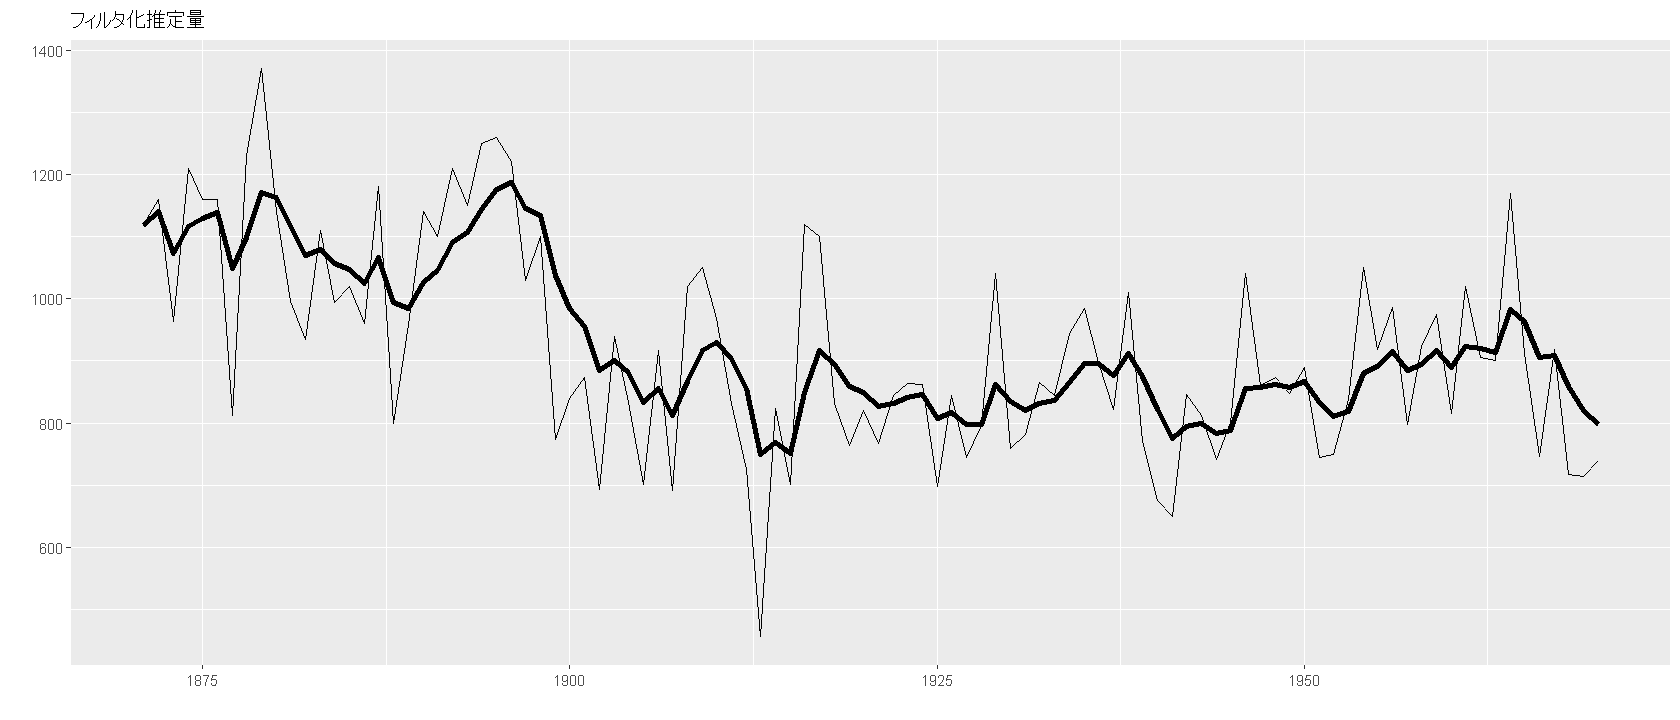

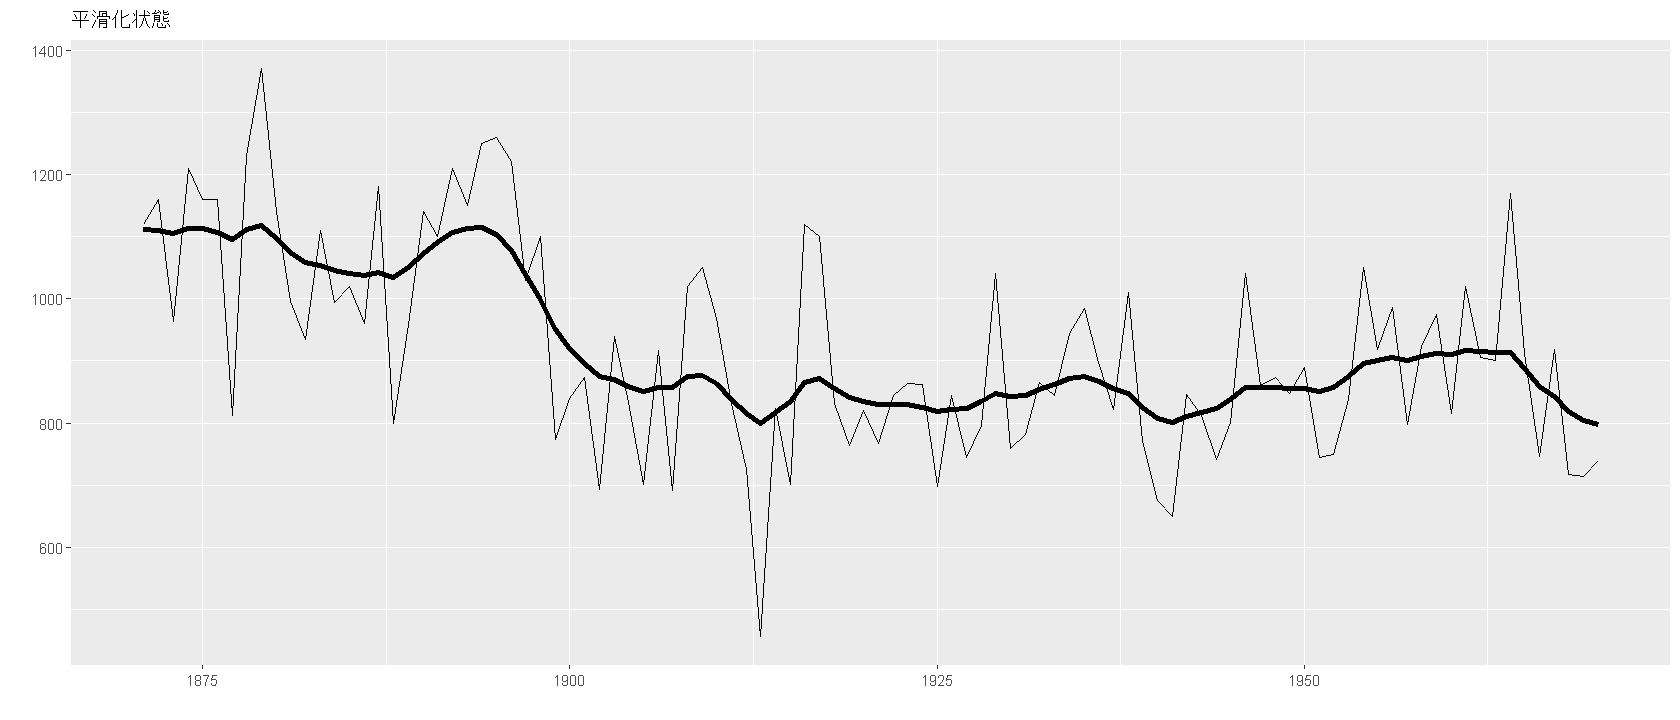

In [56]:
# フィルタ化推定量の図示
autoplot(filter_local_level_dlm, fitted.colour = "black",
         fitted.size = 1.5, main = "フィルタ化推定量")

# 平滑化状態の図示
p_nile <- autoplot(Nile)

autoplot(smooth_local_level_dlm, fitted.colour = "black",
         colour = "black", size = 1.5, main="平滑化状態", p=p_nile)

## Rで実装する散漫カルマンフィルタ

In [57]:
# 状態の推定値
mu_diffuse_filter <- numeric(N + 1)

# 状態の予測誤差の分散
P_diffuse_filter <- numeric(N + 1)

# 散漫初期化を用いると、1時点目のフィルタ化推定量は以下のようになる
mu_diffuse_filter[2] <- Nile[1]
P_diffuse_filter[2] <- sigma_v

In [58]:
# 観測値の予測残差
y_resid_diffuse <- numeric(N)

# 観測値の予測誤差の分散
F_diffuse <- numeric(N)

# カルマンゲイン
K_diffuse <- numeric(N)

In [59]:
# 散漫初期化は2時点目からフィルタリングを行う
for(i in 2:N){
    kekka <- kfLocalLevel(
        y = Nile[i], mu_pre = mu_diffuse_filter[i],
        P_pre = P_diffuse_filter[i], sigma_w = sigma_w, sigma_v = sigma_v
    )
    mu_diffuse_filter[i + 1] <- kekka$mu_filter
    P_diffuse_filter[i + 1] <- kekka$P_filter
    y_resid_diffuse[i] <- kekka$y_resid
    F_diffuse[i] <- kekka$F
    K_diffuse[i] <- kekka$K
}

In [61]:
# 散漫カルマンフィルタ
print(mu_diffuse_filter)

  [1]    0.0000 1120.0000 1140.9524 1072.5894 1117.4155 1130.1417 1138.6551
  [8] 1048.1088 1098.0076 1172.0914 1163.3839 1117.7882 1068.3457 1079.6063
 [15] 1056.4711 1046.6164 1023.2141 1065.5730  993.5546  983.9492 1026.1076
 [22] 1046.0702 1090.3569 1106.4699 1145.2455 1176.2471 1188.0672 1145.3644
 [29] 1133.1089 1036.0934  983.1176  953.6388  883.4957  898.7607  880.9951
 [36]  832.3683  854.9619  810.9367  867.4165  916.7425  930.8602  903.8824
 [43]  855.8263  747.8108  768.3938  750.4571  850.2914  917.7517  894.5854
 [50]  859.3069  848.9581  827.0867  831.9261  840.5911  846.3748  806.2904
 [57]  816.7481  797.0947  796.7990  862.5012  834.5397  820.0756  832.2122
 [64]  835.6669  864.9338  897.1003  897.0732  876.7917  912.7787  874.4763
 [71]  820.8567  774.4286  793.7640  798.6906  783.3753  788.1367  856.1791
 [78]  857.2114  861.7469  858.0331  866.6692  833.5293  810.6932  818.0703
 [85]  880.7276  890.7969  916.5166  884.2285  894.7028  916.3956  889.0030
 [92]  924.3

In [63]:
# 普通のカルマンフィルタ
print(mu_filter)

  [1]    0.0000 1118.8812 1140.4103 1072.2709 1117.1955 1129.9866 1138.5439
  [8] 1048.0302 1097.9501 1172.0492 1163.3531 1117.7658 1068.3295 1079.5944
 [15] 1056.4625 1046.6101 1023.2095 1065.5697  993.5522  983.9474 1026.1063
 [22] 1046.0692 1090.3562 1106.4694 1145.2451 1176.2469 1188.0670 1145.3642
 [29] 1133.1088 1036.0933  983.1175  953.6387  883.4957  898.7607  880.9950
 [36]  832.3683  854.9619  810.9367  867.4165  916.7425  930.8602  903.8824
 [43]  855.8263  747.8108  768.3938  750.4571  850.2914  917.7517  894.5854
 [50]  859.3069  848.9581  827.0867  831.9261  840.5911  846.3748  806.2904
 [57]  816.7481  797.0947  796.7990  862.5012  834.5397  820.0756  832.2122
 [64]  835.6669  864.9338  897.1003  897.0732  876.7917  912.7787  874.4763
 [71]  820.8567  774.4286  793.7640  798.6906  783.3753  788.1367  856.1791
 [78]  857.2114  861.7469  858.0331  866.6692  833.5293  810.6932  818.0703
 [85]  880.7276  890.7969  916.5166  884.2285  894.7028  916.3956  889.0030
 [92]  924.3

## Rで実装する散漫対数尤度

1時点目のデータを使わないことに注意する。

In [64]:
# dnorm関数を使った対数尤度の計算
sum(
    log(
        dnorm(y_resid_diffuse[-1], mean=0, sd=sqrt(F_diffuse[-1]))
    )
)

[1] -637.2855

In [65]:
# 対数尤度の計算式
-1 * ((N - 1)/2) * log(2 * pi) - 1/2*sum(log(F_diffuse[-1]) + y_resid_diffuse[-1]^2 / F_diffuse[-1])

[1] -637.2855

[-1]とすることで1時点目のデータを省く。

## KFASによる散漫カルマンフィルタ

In [67]:
# KFASのパラメタの設定
mod_kfas <- SSModel(
    H = sigma_v, Nile ~ SSMtrend(degree = 1, Q = sigma_w)
)

# 散漫カルマンフィルタの実行
mu_filter_kfas <- KFS(
    mod_kfas, filtering = c("state", "mean"), smoothing = "none"
)

In [68]:
sum((mu_filter_kfas$a - mu_diffuse_filter)^2)

[1] 2.326445e-25

## KFASによる散漫対数尤度の計算

散漫対数尤度はlogLik関数を使うことで計算できる

In [69]:
logLik(mod_kfas)

[1] -637.2855

## dlmとKFASの比較とKFASの優位性

dlmパッケージを使うと簡単に状態空間モデルを推定できるがKFASパッケージの方が以下の点で優れている。

- 散漫カルマンフィルタに対応している
- 計算速度が速い(特にパラメタ推定にかかる時間が短い)
- 線形非ガウシアンなデータに対してもモデル化が可能

基本構造時系列モデルなどやや複雑なモデルだとdlmパッケージだとなかなか計算が終わらない。  


## KFASの使い方

In [70]:
# library(KFAS)
# library(ggplot2)

In [71]:
# 分析の対象となるデータ
# 最後の20年は予測におけるテストデータとする
nile_train <- window(Nile, end = 1950)

# 途中20年間に、欠損があったとする
nile_train[41:60] <- NA

## KFASによる線形ガウス状態空間モデルの推定

- KFASを用いてローカルレベルモデルを推定してみる。
- 欠損値があっても気にすることなくモデルを推定することが可能

In [72]:
# Step1: モデルの構造を決める
build_kfas <- SSModel(
    H = NA,
    nile_train ~ SSMtrend(degree = 1, Q = NA)
)

# Step2: パラメタ推定
fit_kfas <- fitSSM(build_kfas, inits = c(1, 1))

# Step3, 4: フィルタリング・スムージング
result_kfas <- KFS(
    fit_kfas$model,
    filtering = c("state", "mean"),
    smoothing = c("state", "mean")
)

In [73]:
# 観測誤差の分散
fit_kfas$model$H

# 過程誤差の分散
fit_kfas$model$Q

, , 1

         [,1]
[1,] 12782.35

, , 1

         [,1]
[1,] 2489.915

In [74]:
# フィルタ化推定量
mu_filter_kfas <- result_kfas$a[-1]

# 平滑化状態
mu_smooth_kfas <- result_kfas$alphahat

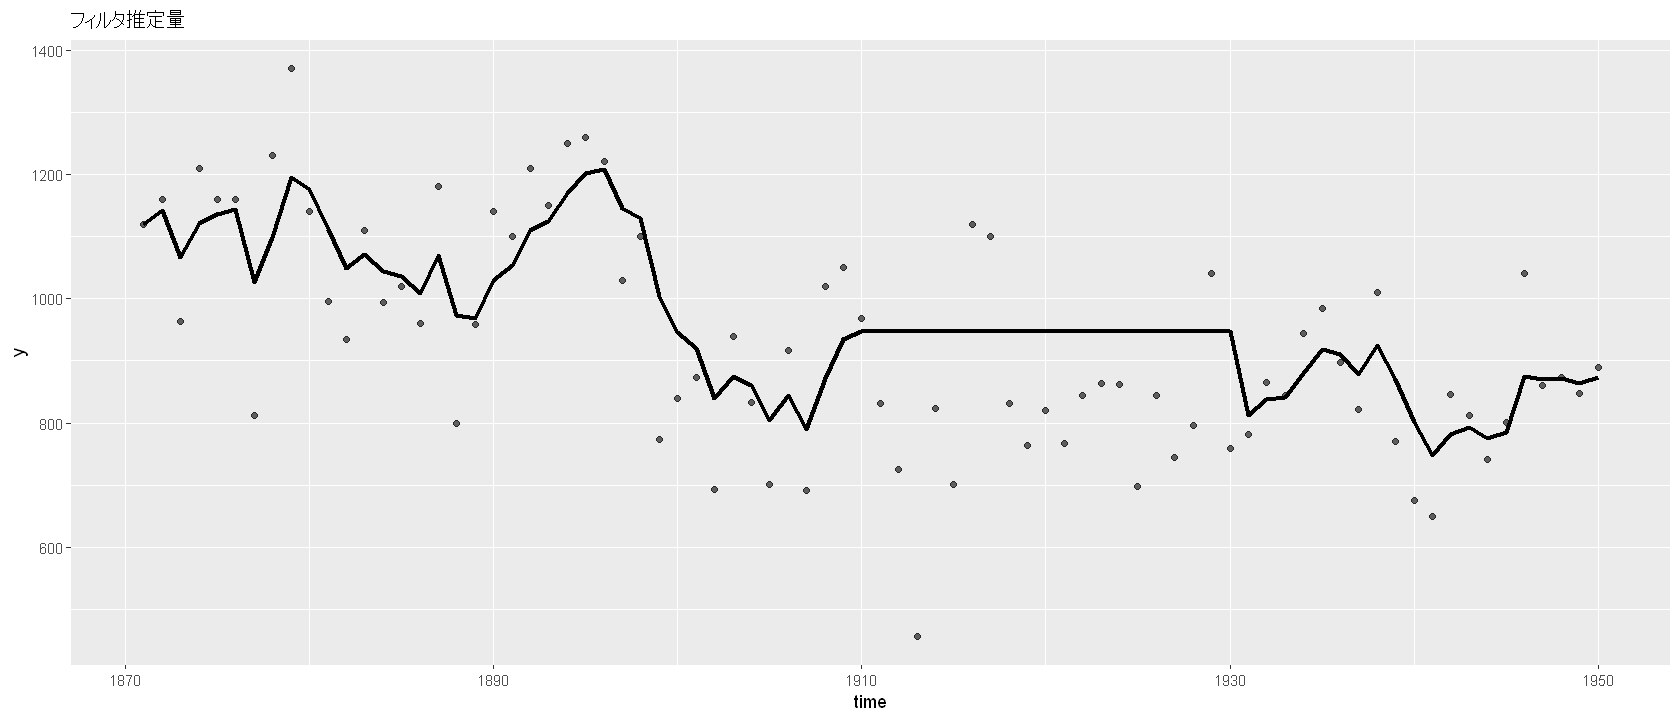

In [76]:
# 結果の図示
df_filter <- data.frame(
    y = as.numeric(Nile[1:80]),
    time = 1871:1950,
    mu_filter = mu_filter_kfas
)

ggplot(data = df_filter, aes(x = time, y = y)) +
    labs(title="フィルタ推定量") + 
    geom_point(alpha = 0.6) + 
    geom_line(aes(y = mu_filter), size = 1.2)

1910 ~ 1930年についてはデータが欠損してずっと同じになっており、これがローカルレベルモデルの補完の特徴。

## KFASによる状態の推定と信頼・予測区間

平滑化状態と、その信頼区間と予測区間を求める。  

- 信頼区間：状態がこの間に収まるだろう区間
- 予測区間：観測値がこの間に収まるだろう区間

予測区間には観測誤差の大きさも加味されていることに注意すること。

In [79]:
# 信頼区間
smooth_conf <- predict(
    fit_kfas$model, interval = "confidence", level = 0.95
)

In [80]:
head(smooth_conf, n=3)

fit,lwr,upr
1113.876,981.9267,1245.826
1112.683,996.8118,1228.555
1102.274,993.8005,1210.747


In [81]:
# 予測区間
smooth_pred <- predict(
    fit_kfas$model, interval = "prediction", level = 0.95
)

In [82]:
head(smooth_pred, n=3)

fit,lwr,upr
1113.876,855.9740,1371.779
1112.683,862.6252,1362.742
1102.274,855.5566,1348.991


## KFASによる予測

predict関数においてn.ahead=20で20時点先まで予測することができる。

In [85]:
forecast_pred <- predict(
    fit_kfas$model, interval = "prediction", level = 0.95, n.ahead=20
)

In [86]:
# 平滑化状態と予測結果を結合させる
estimate_all <- rbind(smooth_pred, forecast_pred)

In [87]:
# 図示のためのデータをまとめる
df_forecast <- cbind(
    data.frame(y = as.numeric(Nile), time=1871:1970),
    as.data.frame(estimate_all)
)

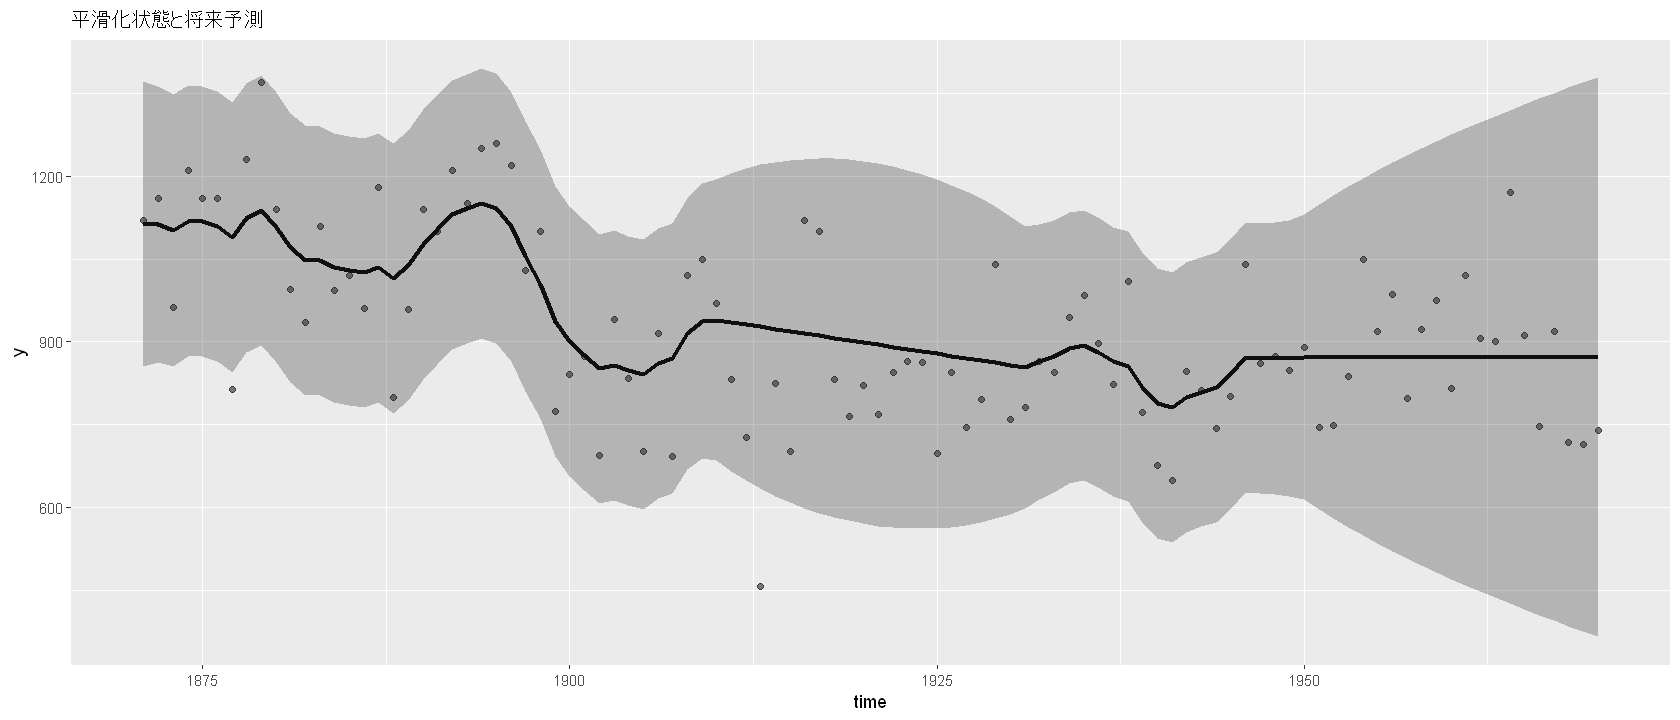

In [88]:
ggplot(data = df_forecast, aes(x=time, y=y)) +
    labs(title = "平滑化状態と将来予測") + 
    geom_point(alpha = 0.5) + 
    geom_line(aes(y = fit), size = 1.2) +
    geom_ribbon(aes(ymin = lwr, ymax = upr), alpha = 0.3)

## ローカルレベルモデルにおける予測

ローカルレベルモデルにおける予測の方法をおさらいしておく。  
将来予測値の点推定値は、最新年の状態の値とまったく同じで変化しません。

In [89]:
tail(smooth_pred, n=1)

,fit,lwr,upr
"[80,]",872.5365,614.6343,1130.439


In [91]:
head(forecast_pred, n=5)

fit,lwr,upr
872.5365,596.7133,1148.360
872.5365,579.8876,1165.185
872.5365,563.9781,1181.095
872.5365,548.8497,1196.223
872.5365,534.3974,1210.676


In [92]:
# 予測区間がどのように広がるか確認する
forecast_se <- predict(
    fit_kfas$model, interval = "prediction", level = 0.95, n.ahead=20, se.fit = T)[, "se.fit"]

In [93]:
# 標準偏差を2乗して分散にする
forecast_se^2

A Time Series:
 [1]  7022.231  9512.146 12002.060 14491.975 16981.890 19471.805 21961.720
 [8] 24451.635 26941.550 29431.465 31921.380 34411.295 36901.209 39391.124
[15] 41881.039 44370.954 46860.869 49350.784 51840.699 54330.614

In [94]:
# 差分をとる
diff(forecast_se^2)

A Time Series:
 [1] 2489.915 2489.915 2489.915 2489.915 2489.915 2489.915 2489.915 2489.915
 [9] 2489.915 2489.915 2489.915 2489.915 2489.915 2489.915 2489.915 2489.915
[17] 2489.915 2489.915 2489.915

2489.915ずつ増えていることがわかる

In [95]:
# 分散の増加量をみる
fit_kfas$model$Q

, , 1

         [,1]
[1,] 2489.915

分散の増加量は、過程誤差の分散の値と一致する。  
過程誤差が積み重なっていき、長期の予測は当たりにくくなるということをわかる。